<a href="https://colab.research.google.com/github/thefoxsaysding/MIPT-Homeworks/blob/main/HW_ML_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предобработка данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, auc, mean_absolute_error, r2_score, mean_absolute_percentage_error, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_curve, f1_score
sns.set();

df = pd.read_csv('https://lms.skillfactory.ru/asset-v1:SkillFactory+MIPTDS+SEPT22+type@asset+block@train.csv', sep = ',')

In [ ]:
df.info() # изучаем датафрейм

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
df.nunique() # исследуем колическтво уникальных значений в столбцах

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [ ]:
df['Age_Range'] = pd.cut(df.Age, [0, 10, 20, 30, 40, 50, 60, 70, 80])
df_grp = df.groupby(['Sex', 'Pclass']) # разобьем общество на группы, чтобы заполнить возраст исходя из пола и класса каюты
df_grp.Age.apply(lambda x: x.fillna(x.median()))
df.Age.fillna(df.Age.median, inplace = True)

/tmp/ipykernel_747573/2562186207.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_grp.Age.apply(lambda x: x.fillna(x.median()))


In [ ]:
df.Embarked.fillna(df.Embarked.mode()[0], inplace = True) # заполняем остальные пустые значения
df.Cabin.fillna('Unknown', inplace = True)
df['cut_Fare']=pd.cut(df['Fare'], bins=3) # разобьем на классы стоимость билетов

In [ ]:
df.info() # проверим

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    object  
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    object  
 11  Embarked     891 non-null    object  
 12  Age_Range    714 non-null    category
 13  cut_Fare     891 non-null    category
dtypes: category(2), float64(1), int64(5), object(6)
memory usage: 86.0+ KB


In [ ]:
df['Relatives_on_board'] = df.Parch + df.SibSp # оптимизируем родственников
df['Family'] = df.Relatives_on_board == 1

In [ ]:
# преобразовываем категориальные переменные в фиктивные переменные
df = pd.concat([df,pd.get_dummies(df.Cabin, prefix="Cabin"),pd.get_dummies(df.Age_Range, prefix="Age_Range"), pd.get_dummies(df.Embarked, prefix="Emb", drop_first = True),pd.get_dummies(df.cut_Fare, prefix="Fare", drop_first = True), pd.get_dummies(df.Pclass, prefix="Class", drop_first = True)], axis=1)
df['Sex'] = LabelEncoder().fit_transform(df['Sex']) 

In [ ]:
df.drop(['Pclass', 'Fare','Cabin', 'cut_Fare','Name','Ticket','Embarked', 'Age_Range', 'SibSp', 'Parch', 'Age'], axis=1, inplace=True) # уберем лишнее


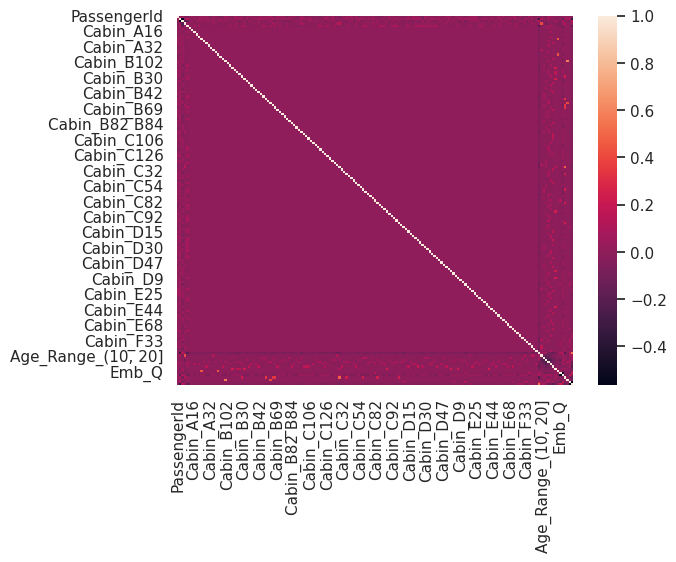

In [ ]:
dataplot = sns.heatmap(df.corr()) # оценим, нет ли корреляции, чтобы избежать переобучения

# Обучение и оценка моделей

In [ ]:
X = df.drop('Survived', axis=1) # запишем признаки в переменную X 
y = df['Survived'] # запишем целевой признак в переменную y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=0) # разделим датафрейм на обучающую и тестовую выборки в соотношении 80%:20%

In [ ]:
# функция для тестирования моделей из лекции, добавим в нее подсчет среднего из 10 прогонов и заполнение итогового датафрейма для визуализации результатов в виде таблицы
result_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC'], index= ['LogisticRegression', 'GaussianNB','KNeighborsClassifier','SVC','RandomForestClassifier'])
def try_model (model, X_train, y_train, X_test, y_test, model_params=None): 
  if model_params is None:
    model_params = dict()
  print(model.__name__)
  pipeline = make_pipeline(StandardScaler(), model(**model_params))
  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  accuracy_mean = 0
  precision_mean = 0
  recall_mean = 0
  f1_mean = 0
  auc_mean = 0
  fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:,1])
  def mean_func (y_test, y_pred, fpr, tpr):
    for i in range (10):
      nonlocal accuracy_mean, precision_mean, recall_mean, f1_mean, auc_mean
      accuracy_mean = (accuracy_mean + accuracy_score(y_test, y_pred)) / 2
      precision_mean = (precision_mean + precision_score(y_test, y_pred)) / 2
      recall_mean = (recall_mean + recall_score(y_test, y_pred)) / 2
      f1_mean = (f1_mean + f1_score(y_test, y_pred)) / 2
      auc_mean = (auc_mean + auc(fpr, tpr)) / 2
  mean_func(y_test, y_pred, fpr, tpr)
  print(f'Accuracy: {accuracy_mean}')
  print(f'Precision: {precision_mean}')
  print(f'Recall: {recall_mean}')
  print(f'F1 score: {f1_score(y_test, y_pred)}')
 
 
  plt.plot(fpr, tpr, color = "k", label = f"ROC curve (area = {auc(fpr, tpr)})")
  plt.plot([0, 1], [0, 1], color = "g")
  plt.legend()
  ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='bone')
  
  global result_df
  result_df.at[f'{model.__name__}','Accuracy'] = accuracy_mean
  result_df.at[f'{model.__name__}','Precision'] = precision_mean
  result_df.at[f'{model.__name__}','Recall'] = recall_mean
  result_df.at[f'{model.__name__}','F1 score'] = f1_mean
  result_df.at[f'{model.__name__}','AUC'] = auc_mean

  return pipeline

LogisticRegression
Accuracy: 0.8036836592178771
Precision: 0.7353922526041667
Recall: 0.7673658288043479
F1 score: 0.7517730496453902


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

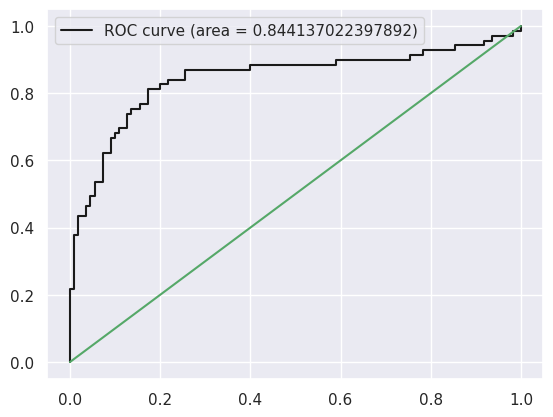

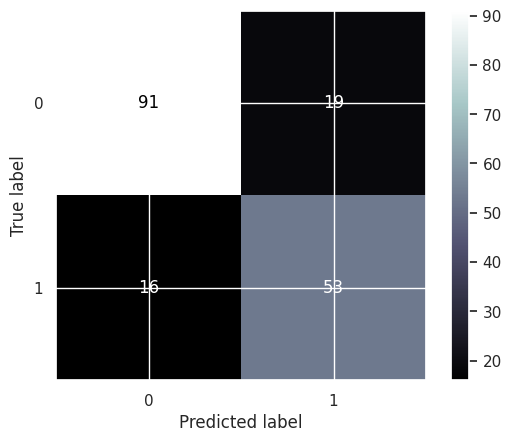

In [ ]:
try_model(LogisticRegression, X_train, y_train, X_test, y_test) # тестируем логистическую регрессию

GaussianNB
Accuracy: 0.6697363826815642
Precision: 0.8563058035714286
Recall: 0.17374320652173914
F1 score: 0.2891566265060241


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

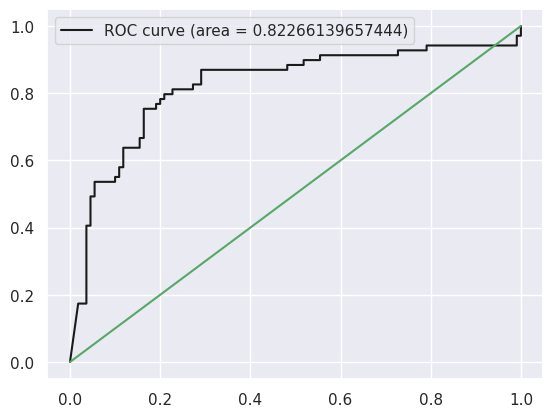

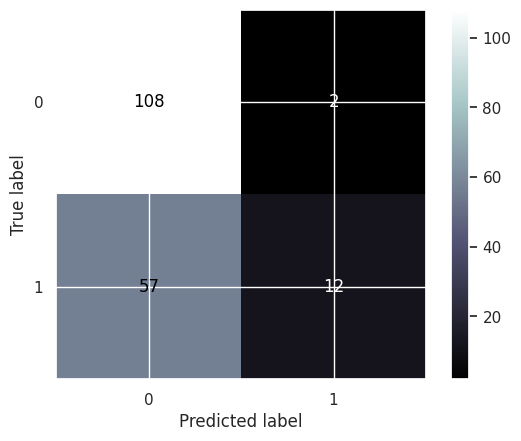

In [ ]:
try_model(GaussianNB, X_train, y_train, X_test, y_test) # тестируем наивный байесовский алгоритм (распределение Гаусса)

KNeighborsClassifier
Accuracy: 0.786940249650838
Precision: 0.8155293367346939
Recall: 0.5791440217391304
F1 score: 0.6779661016949153


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

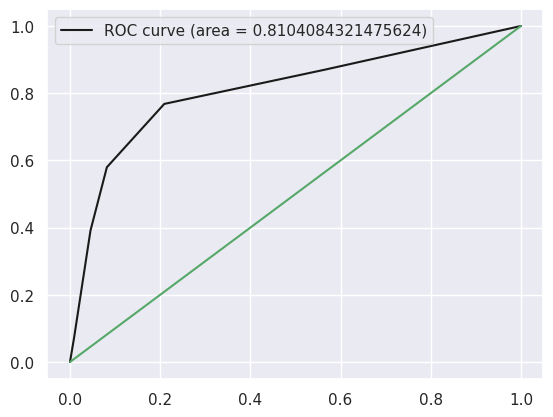

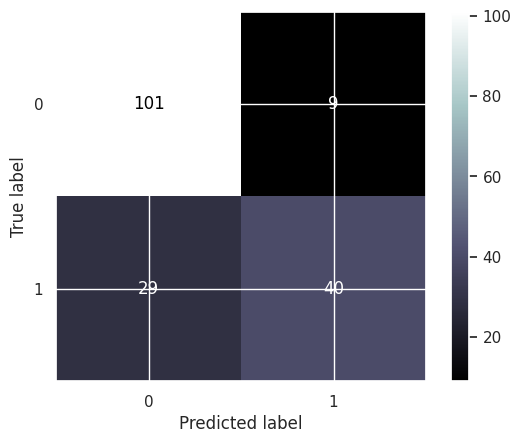

In [ ]:
try_model(KNeighborsClassifier, X_train, y_train, X_test, y_test) # тестируем метод k-ближайших соседей 

SVC
Accuracy: 0.831589341829609
Precision: 0.7818444293478262
Recall: 0.7818444293478262
F1 score: 0.782608695652174


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', probability=True))])

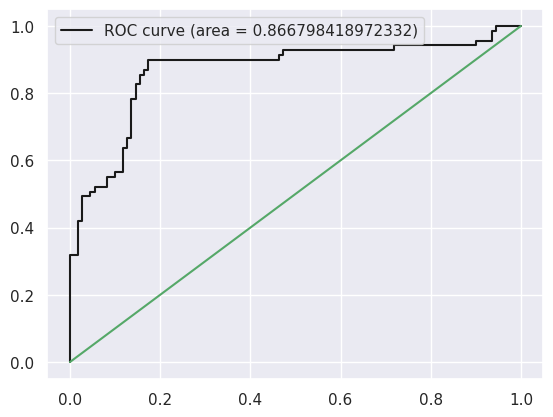

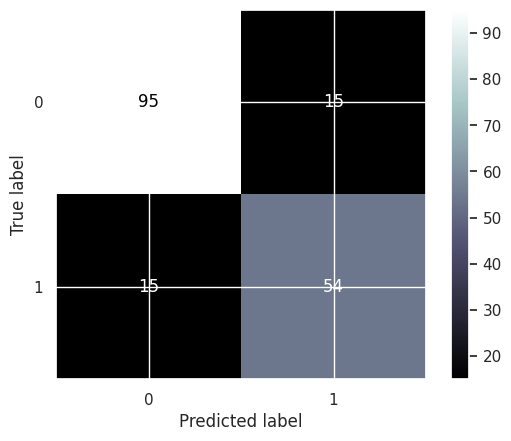

In [ ]:
try_model(SVC, X_train, y_train, X_test, y_test, model_params=dict(kernel='linear', probability=True)) # тестируем метод опорных векторов 

RandomForestClassifier
Accuracy: 0.8539138879189945
Precision: 0.8635626324152543
Recall: 0.7384086277173912
F1 score: 0.796875


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=25))])

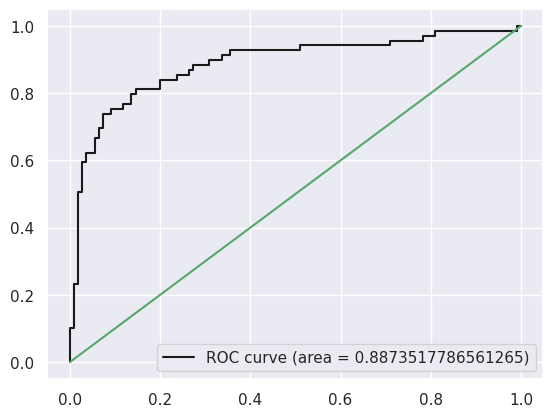

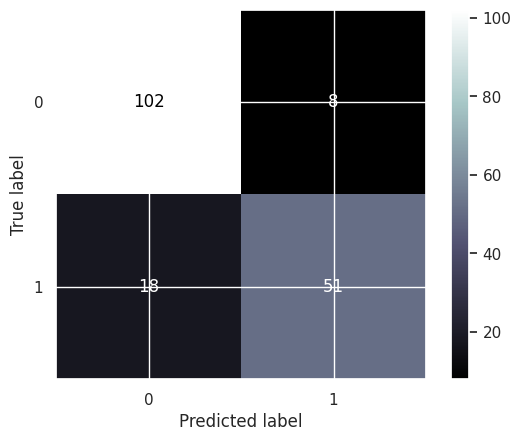

In [ ]:
try_model(RandomForestClassifier, X_train, y_train, X_test, y_test, model_params=dict(n_estimators=100, max_depth=25)) # тестируем случайный лес

# Выбор метрики

In [ ]:
display(result_df.style.highlight_min(color = 'red').highlight_max(color = 'green')) # выведем сводную таблицу результатов тестирования моделей
# подсветим красным худший результат, зеленым - лучший

,Accuracy,Precision,Recall,F1 score,AUC
LogisticRegression,0.803684,0.735392,0.767366,0.751039,0.843313
GaussianNB,0.669736,0.856306,0.173743,0.288874,0.821858
KNeighborsClassifier,0.786940,0.815529,0.579144,0.677304,0.809617
SVC,0.831589,0.781844,0.781844,0.781844,0.865952
RandomForestClassifier,0.853914,0.863563,0.738409,0.796097,0.886485


Из полученных сводных данных видно, что лучше всего проявили себя модели SVC (метод опорных векторов) и RandomForestClassifier (случайный лес).
GaussianNB в данном случае возвращает низкий Recall и, как следствие, F1 score.

В целом, рекомендуется использование моделей SVC (метод опорных векторов) и RandomForestClassifier (случайный лес), более точную рекомендацию можно дать после уточнения задачи (например, выявить всех выживших, либо выявить всех погибших, либо дать наиболее точно предсказание выживаемости конкретного пассажира и т.п.)